## Программа Reboot 2020 поток 1 КУ Сбербанка
### выполнил Малинкин Павел Борисович

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
# Запгрузим нужные библиотеки
import torch
import pickle
import numpy as np
from skimage import io
import random
import math

import PIL
from PIL import Image
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

import torch.nn as nn
import torch.optim as optim
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.nn import functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
# Проверим доступность GPU

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

!nvidia-smi

CUDA is available!  Training on GPU ...
Mon Jul 27 09:58:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.92       Driver Version: 442.92       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8    N/A /  N/A |     76MiB /  3072MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                    

In [3]:
# Вывод данных о загруженности памяти
from GPUtil import showUtilization as gpu_usage
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


In [4]:
torch.__version__, PIL.__version__

('1.5.0', '5.3.0')

In [5]:
# Здесь можно взять набор картинок для обучения

#from google.colab import drive
#drive.mount('/content/gdrive/')
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

In [7]:
# Подготовим библиотеку албументации картинок
import albumentations
from albumentations.pytorch import ToTensor

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, ElasticTransform, 
    ChannelShuffle,RGBShift, Rotate
)

def augment(aug, image):
    return aug(image=image)['image']

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [8]:
SEED = 21

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Настройка размера батча и количества эпох
model_batch_size = 16
model_num_epochs = 8

In [9]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet
 

In [10]:
import albumentations as albm
from albumentations.pytorch import ToTensor

class SimpsonsDataset(Dataset):
    """
#    Датасет с картинками, который паралельно подгружает их из папок
#    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def augment(self, aug, image):
        return aug(image=image)['image']
        
    def load_sample(self, file):
        image = Image.open(file)
#        image.load()
        if self.mode == 'train':
            image_np = np.array(image)       
            image = Image.fromarray(self.augment(self.pil_transform(), image_np))
        #image.save('out.jpg')
        return image

    def pil_transform(self, p=1):    # дополнительная функция для албументации картинок
        return Compose([
                    albm.RandomResizedCrop(256, 256),  # растянем и вырежем центр картинки
                    albm.OneOf([
                        # apply one of transforms to 50% of images
                        albm.RandomContrast(), # apply random contrast
                        albm.RandomGamma(), # apply random gamma
                        albm.RandomBrightness(), # apply random brightness
                        albm.ShiftScaleRotate(),
                        albm.ToGray(p=0.2),
                        ],
                        p = 0.5),            
                    ])     
  

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],) 
        ])       
        
        x = self.load_sample(self.files[index])
        # в метод load_sample добавлена албументация картинок
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [12]:
TRAIN_DIR = Path('./data/trainset')
TEST_DIR = Path('./data/testset')


train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3, stratify=train_val_labels)

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

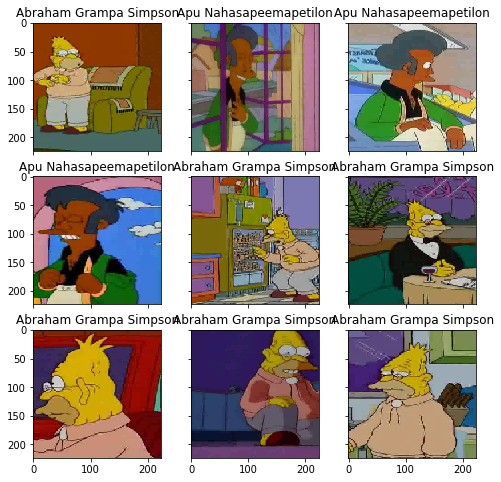

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

### Построение нейросети

In [18]:
# Модель на основе baseline (в итоге не использовалась). Пробовал также вариант использования AlexNet и VGG16
class ConvModel(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=164, kernel_size=3),
            nn.BatchNorm2d(164),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 164, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )        
        self.out = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 164)
        x = self.fc1(x)
        x = self.fc2(x)

        logits = self.out(x)
        return logits

In [21]:
# Будем использовать ResNet50 
simple_cnn = models.resnet50(pretrained=True).to(DEVICE)
    
for child in list(simple_cnn.children())[:-10]:  # разморозим 10 последних слоев
    for param in child.parameters():
        param.requires_grad = False    
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою из fitcher extaction ResNet50
num_features = 2048    

# Заменяем Fully-Connected слой на наш вариант
simple_cnn.fc = nn.Sequential(
                nn.Linear(num_features, 42)).to(DEVICE)


In [22]:
# функция обучения 
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):    
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        scheduler.step()   # Update the LR
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [23]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [24]:
# Используем изменяемый по циклу learning_rate 
lr_max = 3*10e-3
end_lr = lr_max
factor = 6

def cyclical_lr(stepsize, min_lr=3e-2, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [25]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    learning_rate = 0.01
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:      
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

         # Define the optimizer    
        step_size = 4*len(train_loader)
        clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
        scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])
        
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):         
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [27]:
n_classes = len(np.unique(train_val_labels))

print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

Запустим обучение сети.

In [28]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [29]:
# Обучение модели
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=model_num_epochs, batch_size=model_batch_size)

epoch:   0%|                                             | 0/8 [00:00<?, ?it/s]

loss 1.0609159143290112


epoch:  12%|████▏                            | 1/8 [22:28<2:37:18, 1348.32s/it]


Epoch 001 train_loss: 1.0609     val_loss 0.3065 train_acc 0.7350 val_acc 0.9194
loss 0.9615007184330436


epoch:  25%|████████▎                        | 2/8 [42:57<2:11:16, 1312.69s/it]


Epoch 002 train_loss: 0.9615     val_loss 0.4248 train_acc 0.7527 val_acc 0.8886
loss 0.8550900582595058


epoch:  38%|███████████▋                   | 3/8 [1:03:24<1:47:13, 1286.78s/it]


Epoch 003 train_loss: 0.8551     val_loss 0.4215 train_acc 0.7769 val_acc 0.8963
loss 0.8557050347954619


epoch:  50%|███████████████▌               | 4/8 [1:24:10<1:24:58, 1274.53s/it]


Epoch 004 train_loss: 0.8557     val_loss 0.3863 train_acc 0.7763 val_acc 0.9005
loss 0.7383618349672006


epoch:  62%|███████████████████▍           | 5/8 [1:44:42<1:03:05, 1262.00s/it]


Epoch 005 train_loss: 0.7384     val_loss 0.2763 train_acc 0.8085 val_acc 0.9260
loss 0.6176760786589947


epoch:  75%|████████████████████████▊        | 6/8 [2:05:10<41:43, 1251.74s/it]


Epoch 006 train_loss: 0.6177     val_loss 0.2340 train_acc 0.8396 val_acc 0.9389
loss 0.515261749741096


epoch:  88%|████████████████████████████▉    | 7/8 [2:25:40<20:45, 1245.02s/it]


Epoch 007 train_loss: 0.5153     val_loss 0.1755 train_acc 0.8655 val_acc 0.9535
loss 0.4258661012063618


epoch: 100%|█████████████████████████████████| 8/8 [2:46:04<00:00, 1245.51s/it]


Epoch 008 train_loss: 0.4259     val_loss 0.1281 train_acc 0.8873 val_acc 0.9655


Построим кривые обучения

In [30]:
# Смотрим на лосс ошибки
loss, acc, val_loss, val_acc = zip(*history)

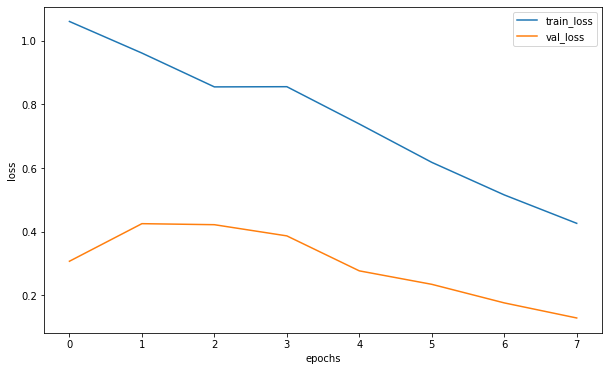

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [33]:
# сохранение модели
with open('model_sim.pkl', 'wb') as model_file:
    pickle.dump(simple_cnn, model_file)

C:\Users\Pavel\Anaconda3\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [34]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [35]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [36]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [37]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [38]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
y_pred_ls = [label_encoder.classes_[i] for i in y_pred]
label_classes = list(label_encoder.classes_)
preds_class = [label_classes.index(i) for i in y_pred_ls]

In [39]:
actual_labels

[2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0]

In [40]:
preds_class

[2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [41]:
# Качество классификаци на тестовой выборке

from sklearn.metrics import f1_score 
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro') 

1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

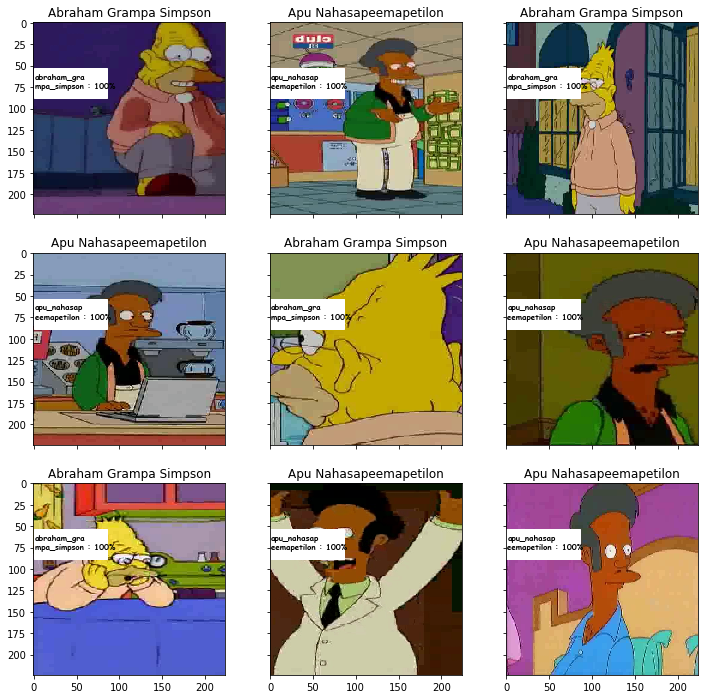

In [42]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [43]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=model_batch_size)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [45]:
import pandas as pd
#my_submit = pd.read_csv('sample_submission.csv')
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [46]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [47]:
my_submit.to_csv('my_submit_ResNet.csv', index=False)


## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


### Лучший результат получился при: разморожено 10 слоев.
### ResNet50 children[:-10], model_batch_size = 16, model_num_epochs = 8, lr = 0.01 with cyclical step. 

### Модель обучалась 2:42:46
### Результат - 0.99362
#### Ссылка на leaderboard  https://www.kaggle.com/c/journey-springfield/leaderboard
#### Участник Павел_Малинкин_44905784